<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/ClasificadorBinario_sinProcesar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai -Uq

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 19.4 MB/s 
     |████████████████████████████████| 60 kB 3.9 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

In [2]:
!wget https://www.dropbox.com/s/1isaa8xrrv0x6n4/datasetComprimido.zip?dl=0 --no-verbose -O datasetComp.zip

2022-06-15 18:03:42 URL:https://uce49c9c7d179b8c268a504d4af9.dl.dropboxusercontent.com/cd/0/inline2/BnQ-a2YMquhmuH-XOPSaQMl6YSTr_TL1KstNgwHrZK911TRHwf2HP9Zk6rdc7TcrnLJQwx6DOWR2AfCs5fWDiW0pHJKiFQcgVrQu_cqdGPyRZTr7FQia3PVLMDjivRmsy1zdxuypKX48726Jia_gOqXbXVi9xNksKN0viqGOJgyvN-To2Wlq0o182jsrHtPZ1_vb07snh2Aio7q_Nywl0qi64xKwNB5PgK71-thEPnCCRTo9waCm8NJijb2QmXryLNrnfmaVgrLqb_KFp-RRl75QdZ2Aaw2kjx4Eve_y_8Cl5cfOR2zF-Cm669CHzOkKbc0CDqHnL0TNIHKsRI7bjt6lcxUmwkUDbFOwJ6N7X8P-HRQrIc3H-CWWPKxWIIuo9kzY4odInCRHAmTYP_kgDSicbLUEqT2pO2OIMI3KUBM3ww/file [144922725/144922725] -> "datasetComp.zip" [1]


In [5]:
!unzip -qq datasetComp.zip

In [3]:
trainPath = Path('Training_Set_C/')
testPath  = Path('Test_Set_C/')
valPath  =  Path('Evaluation_Set_C/')

In [6]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [7]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [11]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [8]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [9]:
path = Path('dataset')

In [12]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [13]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [14]:
dls = db.dataloaders(path,bs=128)

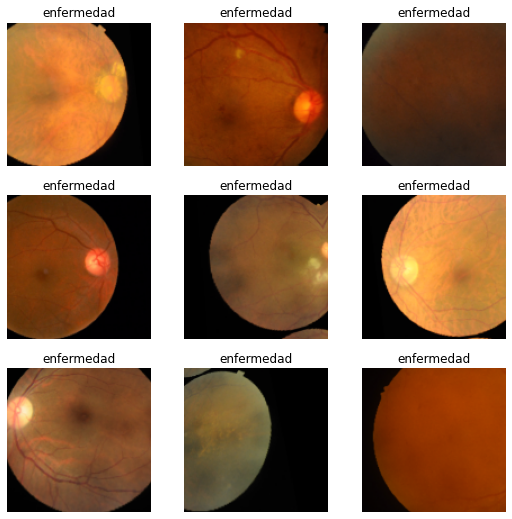

In [15]:
dls.show_batch()

In [16]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()  
]

In [17]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.012022644281387329, steep=9.12010818865383e-07, valley=0.0006918309954926372, slide=0.004365158267319202)

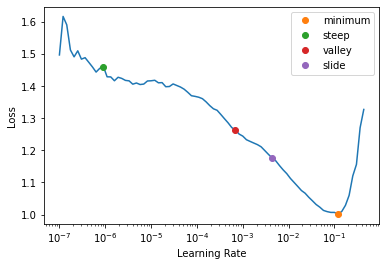

In [18]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))